# Starter example Mac

Some specific commands for Jupyter:

In [1]:
# Jupyter Notebook with widget matplotlib plots
%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
#%matplotlib inline
%load_ext autoreload
%autoreload 2

Load necessary modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
sys.path.append('/Users/nbruggemann/Promotion/src/pyicon/')
import pyicon as pyic

## Names and paths

Define the name of the simulation, its grid, the path to the data and paths to the grid:

In [3]:
run = 'nib0002'
runname = 'icon_08'
gname = 'r2b4'
lev = 'L40'

path_data     = f'/Users/nbruggemann/work/icon_playground/icon_r2b4_test_data/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_grid     = f'/Users/nbruggemann/work/icon_playground/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

## Pyicon IconData object

Create a pyicon IconData object. This object contains information about the grid, and the time steps which are in the given data directory.

In [4]:
IcD = pyic.IconData(
               fname        = run+'_????????????????.nc',
               path_data    = path_data,
               path_grid    = path_grid,
               gname        = gname,
               lev          = lev,
               #path_ckdtree = path_ckdtree,
               #section_name = '',
               #fpath_fx     = fpath_fx,
               do_triangulation = True,
               omit_last_file   = False,
               calc_coeff = False,
              )

In [135]:
# lon1, lat1 = -60, 53
# lon2, lat2 = -50, 62
# along_const_lat = False

# Drake passage
lon1, lat1 = -60.5, -64.3                                                        
lon2, lat2 = -67, -55. 
along_const_lat = False

# lon1, lat1 = -100, 26
# lon2, lat2 = -5, 26
# along_const_lat = True

# lon1o, lat1o = 16.6, 77.
# lon2o, lat2o = 19.5, 69.8
# along_const_lat = False

In [136]:
lon1o, lat1o = lon1, lat1
lon2o, lat2o = lon2, lat2
iv1 = np.argmin((IcD.vlon-lon1o)**2+(IcD.vlat-lat1o)**2)
lon1, lat1 = IcD.vlon[iv1], IcD.vlat[iv1]
iv2 = np.argmin((IcD.vlon-lon2o)**2+(IcD.vlat-lat2o)**2)
lon2, lat2 = IcD.vlon[iv2], IcD.vlat[iv2]

# make sure that we are slightly next to target points
lon1 += 1e-10
lat1 += 1e-10
lon2 += 1e-10
lat2 += 1e-10

In [137]:
#def find_section_edges_orientation_2(IcD, lon1, lat1, lon2, lat2, along_const_lat=False):
if True:
  # --- renaming 
  elon = IcD.elon
  elat = IcD.elat
  clon = IcD.clon
  clat = IcD.clat
  vlon = IcD.vlon
  vlat = IcD.vlat

  # --- path along great circle
  if not along_const_lat:
    p1 = lon1*np.pi/180.
    t1 = lat1*np.pi/180.
    p2 = lon2*np.pi/180.
    t2 = lat2*np.pi/180.
    p3 = IcD.vlon*np.pi/180.
    t3 = IcD.vlat*np.pi/180.
    crit = ( np.cos(p3)*np.cos(t3)*( np.sin(p1)*np.cos(t1)*np.sin(t2) - np.sin(t1)*np.sin(p2)*np.cos(t2) )
           + np.sin(p3)*np.cos(t3)*( np.sin(t1)*np.cos(p2)*np.cos(t2) - np.cos(p1)*np.cos(t1)*np.sin(t2) )
           + np.sin(t3)           *( np.cos(p1)*np.cos(t1)*np.sin(p2)*np.cos(t2) - np.sin(p1)*np.cos(t1)*np.cos(p2)*np.cos(t2) ) )
    mask_e = crit[IcD.edge_vertices[:,0]]*crit[IcD.edge_vertices[:,1]]<0.
    if False:
        # --- cut to longitude range
        if lon1<lon2:
          mask_e[ (elon<lon1) | (elon>lon2) ] = False
        elif lon1>lon2:
          mask_e[ (elon>lon1) | (elon<lon2) ] = False
        # --- cut to latitude range if lon1==lon2
        else:
          mask_e[ (elat<lat1) | (elat>lat2) ] = False
          mask_e[ np.abs(elon-lon1)>5. ] = False
  # --- path along const. latitude
  else:
    crit = (vlat-lat1)
    mask_e = crit[IcD.edge_vertices[:,0]]*crit[IcD.edge_vertices[:,1]]<0.
    mask_e[ (elon<lon1) | (elon>lon2) ] = False

  # --- all vertices belonging to edges
  iv_all = IcD.edge_vertices[mask_e,:]
  # --- delete vertices that only occur once - but not start and end vertex
  itmp, ind, cnts = np.unique(iv_all, return_index=True, return_counts=True)
  iv_inval = itmp[cnts==1]
  iv_s = iv_all.flatten()[np.argmin((vlon[iv_all]-lon1)**2+(vlat[iv_all]-lat1)**2)]
  iv_e = iv_all.flatten()[np.argmin((vlon[iv_all]-lon2)**2+(vlat[iv_all]-lat2)**2)]
  iv_inval = iv_inval[iv_inval!=iv_s]
  iv_inval = iv_inval[iv_inval!=iv_e]
  # --- all edges
  ie_all = np.where(mask_e)[0]
  # --- valid edges are those who are not attached to invalid vertices 
  mtmp = np.isin(ie_all,IcD.edges_of_vertex[iv_inval])
  ie_valid = ie_all[mtmp==False]
  iv_valid = IcD.edge_vertices[ie_valid,:]

#   # --- find start and end vertices
#   i, c = np.unique(iv_valid, return_counts=True)
#   iv_se = i[c==1]
#   iv_start = iv_se[np.argmin((vlon[iv_se]-lon1)**2+(vlat[iv_se]-lat1)**2)]
#   iv_next = iv_start
#   # --- allocate final lists
#   iv_sec = [iv_start]
#   ie_sec = []
#   or_sec = []

In [138]:
#iv_valid = iv_all
#ie_valid = ie_all
iv_all_2 = np.unique(iv_valid)
iv1 = iv_all_2[ np.argmin((vlon[iv_all_2]-lon1)**2+(vlat[iv_all_2]-lat1)**2) ] 
iv2 = iv_all_2[ np.argmin((vlon[iv_all_2]-lon2)**2+(vlat[iv_all_2]-lat2)**2) ]

In [139]:
# there are two edges belonging to the potential start vortex
ind = np.where(iv_valid == iv1) # 1st dim: edges that match; 2nd dim: vert of edge that match

if ind[0].size==1:
    iv1ed = iv_valid[ind[0][0],1-ind[1][0]]
    iv_next = iv1ed
    iel_prev = ind[0][0]
    ivl_prev = ind[1][0]
else:
    # ind of other edge vortex (edge 1/2)
    iv1ed = iv_valid[ind[0][0],1-ind[1][0]]
    iv2ed = iv_valid[ind[0][1],1-ind[1][1]]
    # decide which edge is start edge by finding associated vortex of both edges 
    # and check which is closer to final vertex
    d1 = (vlon[iv1ed]-lon2)**2+(vlat[iv1ed]-lat2)**2
    d2 = (vlon[iv2ed]-lon2)**2+(vlat[iv2ed]-lat2)**2
    if d1 < d2:
        iv_next = iv1ed
        iel_prev = ind[0][0]
        ivl_prev = ind[1][0]
    else:
        iv_next = iv2ed
        iel_prev = ind[0][1]
        ivl_prev = ind[1][1]

In [140]:
iv_search = 1*iv_valid
#iel_prev = 10
#ivl_prev = 0
#iv_prev = iv_search[iel_prev, ivl_prev]
ie_list = [ie_valid[iel_prev]]
iv_list = [iv_valid[iel_prev, ivl_prev]]
iv_end = iv2

icount = -1
while True:
    icount += 1
    iv_next = iv_valid[iel_prev, 1-ivl_prev]
    iv_list.append(iv_next)
    if iv_next==iv_end:
        break
    elif icount > 10e6:
        print('did not find final vertex')
        break
    iv_search[iel_prev,:] = np.ma.masked
    iel_prev = np.where(iv_search==iv_next)[0][0]
    ivl_prev = np.where(iv_search==iv_next)[1][0]
    ie_list.append(ie_valid[iel_prev])
    print(vlon[iv_list[-1]], vlat[iv_list[-1]])
    #print('iv: ', iv_valid[iel_prev, ivl_prev])
    #print('ie: ', ie_valid[iel_prev])

-57.47757249812224 -62.00757204019437
-62.248509157508266 -62.35799819257557
-60.57511055020556 -60.37615134693651
-65.11103418957387 -60.637693604673196
-63.35857090810921 -58.67601535400363
-67.66531784288907 -58.85907532334341
-65.86222109008705 -56.91603866806415


In [141]:
or_list = np.zeros((len(ie_list)))
for nn in range(len(ie_list)):
    iel = IcD.edges_of_vertex[iv_list[nn],:]==ie_list[nn]
    or_list[nn] = IcD.edge_orientation[iv_list[nn], iel]

In [142]:
if False:
  for nn in range(ie_valid.size):
    # --- save old value
    iv_previous = iv_next
    # --- index where vertex list matches iv_next
    itmp = np.where((iv_valid==iv_next).sum(axis=1))[0][0]
    # --- next edge
    ie_next = ie_valid[itmp]
    # --- next vertex
    iv_next = iv_valid[itmp,iv_valid[itmp,:]!=iv_previous][0]
    # --- orientation
    #itmp2 = np.where(IcD.vertices_of_vertex[iv_previous,:]==iv_next)[0][0]
    ##itmp2 = np.where((iv_valid==[iv_previous,iv_next]).sum(axis=1))[0]
    ##if itmp2.size==1:
    ##  itmp2 = itmp2[0]
    ##else:
    ##  itmp2 = np.where((iv_valid==[iv_next,iv_previous]).sum(axis=1))[0][0]
    itmp2 = np.where(IcD.edges_of_vertex[iv_previous]==ie_next)[0][0]
    or_next = IcD.edge_orientation[iv_previous, itmp2]
    # --- delete iv entry such that it is not found again
    iv_valid[itmp,:] = np.ma.masked
    # --- save indices
    iv_sec.append(iv_next)
    ie_sec.append(ie_next)
    or_sec.append(or_next)
    
    if iv_next==iv_e:
      break

  #print(np.array(ie_sec).size)
  #print(ie_sec)

  # --- output
  edge_mask = np.zeros((IcD.elon.size))
  edge_mask[ie_sec] = or_sec

#   return edge_mask

In [143]:
IcD.edge_orientation.shape, IcD.edges_of_vertex.shape

((8046, 6), (8046, 6))

In [144]:
iv_valid.size

338

<IPython.core.display.Javascript object>


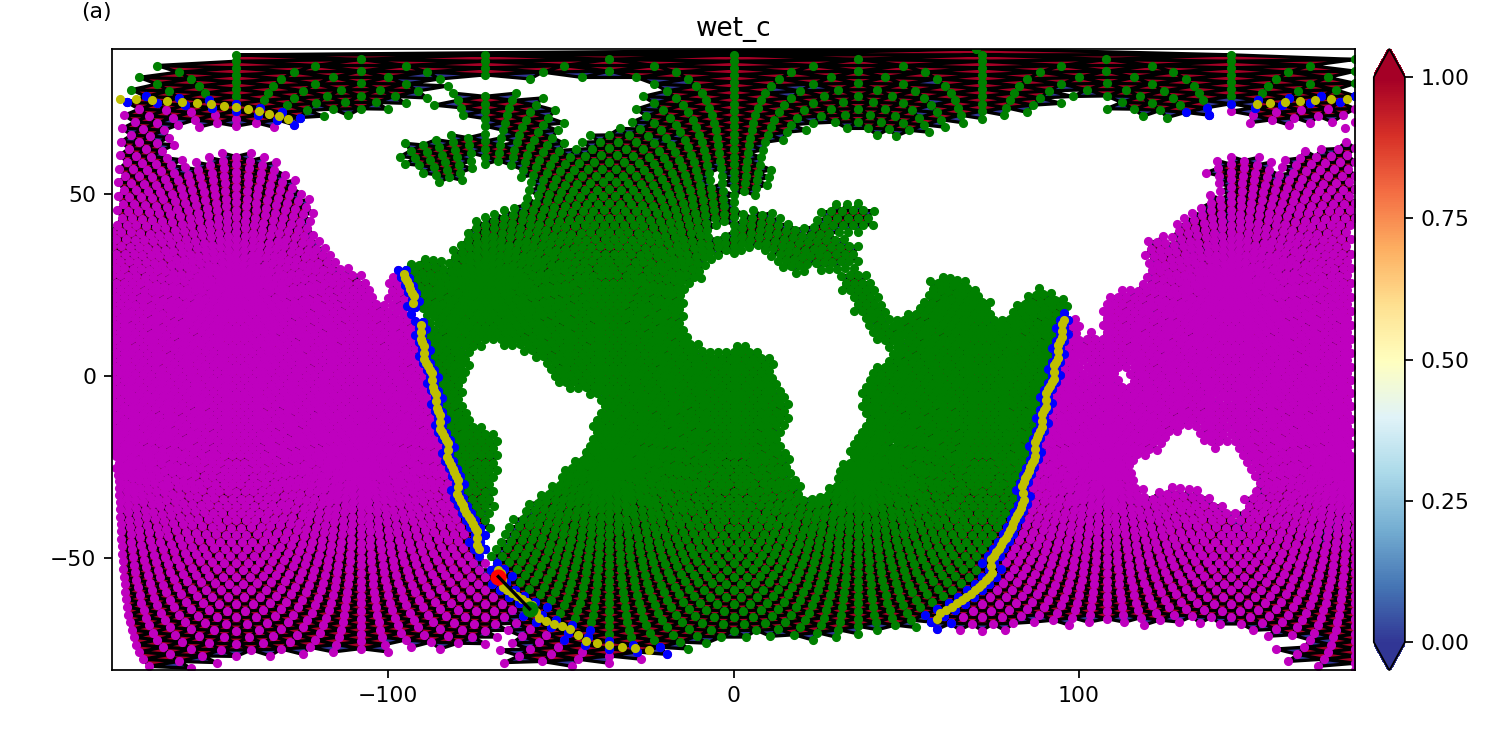

Text(0.5, 1.0, 'wet_c')

In [145]:
hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=0.5, fig_size_fac=2.5)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(IcD.Tri, IcD.wet_c[0,:], ax=ax, cax=cax, clim='auto')
ax.triplot(IcD.Tri, color='k', zorder=1.)
ax.scatter(IcD.vlon[crit<=0], IcD.vlat[crit<=0], s=10, c='g', zorder=2)
ax.scatter(IcD.vlon[crit>0 ], IcD.vlat[crit>0 ], s=10, c='m', zorder=2)
ax.scatter(IcD.vlon[iv_all], IcD.vlat[iv_all], s=10, c='b', zorder=2)
ax.scatter(IcD.elon[ie_valid], IcD.elat[ie_valid], s=10, c='y', zorder=2)
#ax.scatter(IcD.vlon[iv_valid], IcD.vlat[iv_valid], s=10, c='c', zorder=2)
# ax.scatter(IcD.elon[ie_list], IcD.elat[ie_list], s=50, c='y', marker='o', zorder=2)
# ax.scatter(IcD.vlon[iv_list], IcD.vlat[iv_list], s=50, c='c', marker='o', zorder=2)
ax.scatter(IcD.vlon[iv1], IcD.vlat[iv1], s=40, c='g', zorder=2)
ax.scatter(IcD.vlon[iv2], IcD.vlat[iv2], s=40, c='r', zorder=2)
#ax.scatter(IcD.vlon[iv_next], IcD.vlat[iv_next], s=100, c='k', zorder=2)
ax.plot([lon1, lon2], [lat1, lat2], color='k', linestyle='-')
ax.set_title('wet_c')
# ax.set_ylim(40,70)
# ax.set_xlim(-70,-10)